In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.base import BaseEstimator
from sklearn.linear_model import RidgeClassifier, RidgeCV
from sklearn import svm




### Набор данных с кристаллизацией

In [2]:
crys_df = pd.read_excel("lysozyme.xlsx")
crys_df = crys_df[["precipitater", "crystallization", "R", "dimer", "octamer"]]
crys_df.index = crys_df["precipitater"]
crys_df.drop("precipitater", axis=1, inplace=True)
crys_df.head()

,crystallization,R,dimer,octamer
precipitater,,,,
1_1,нет,14.3,0.0,0.0
1_10,нет,15.5,9.3,0.0
1_11,нет,15.0,5.4,0.0
1_13,нет,14.3,0.0,0.0
1_14,нет,14.3,0.0,0.0


### Спектры

In [3]:
# создаю словарь, где ключ - это id объекта, а значение - таблица с углами и интенсивностями
spectr_dir_root = "lysozyme_saxs/"
spectr_rows = 2578
skiprows = 3

spectr_df = {}
for file in os.listdir(spectr_dir_root):
    spec = pd.read_csv(os.path.join(spectr_dir_root, file), skiprows=skiprows, 
                       names=["scattering_angle", "intensity", "err"], 
                       nrows=spectr_rows, sep=" ", skipinitialspace=True)
    name_splitted = file.split("_")
    spectr_df[name_splitted[1][-1] + "_" + name_splitted[2]] = spec.drop("err", axis=1)

In [4]:
# Проверка на одинаковость углов (чтобы потом склеить все интенсивности)
template = np.array(spectr_df["1_1"]["scattering_angle"])
for obj_idx in spectr_df.keys():
    if np.any(template != np.array(spectr_df[obj_idx]["scattering_angle"])):
        print(obj_idx)

1_13
1_16
1_23
1_61
2_19


In [5]:
spectr_df["1_61"] # на одну запись меньше (другие также надо проверить)

,scattering_angle,intensity
0,1.496580e-01,1.666831e-02
1,1.524400e-01,1.643593e-02
2,1.552220e-01,1.652003e-02
3,1.580030e-01,1.690230e-02
4,1.607850e-01,1.644929e-02
...,...,...
2573,7.307080e+00,5.971450e-05
2574,7.309860e+00,-4.783830e-04
2575,7.312650e+00,6.471455e-04
2576,7.315430e+00,6.625720e-04


In [6]:
spectr_df["1_1"] # не хватает именно последнего значения для угла 7.318210. Удалим во всех таблицах

,scattering_angle,intensity
0,0.149658,0.016250
1,0.152440,0.015911
2,0.155222,0.015469
3,0.158003,0.016117
4,0.160785,0.015550
...,...,...
2573,7.307080,0.000300
2574,7.309860,-0.000509
2575,7.312650,0.000669
2576,7.315430,0.000504


In [7]:
# удаляем последнюю строку и переводим во float из object
for obj_idx in spectr_df.keys():
    spectr_df[obj_idx] = spectr_df[obj_idx].iloc[:-1].astype(float)

In [8]:
# Проверка на одинаковость углов
template = np.array(spectr_df["1_1"]["scattering_angle"])
for obj_idx in spectr_df.keys():
    if np.any(template != np.array(spectr_df[obj_idx]["scattering_angle"])):
        print(obj_idx)

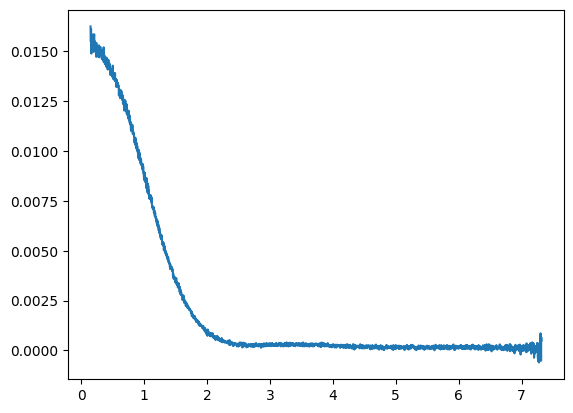

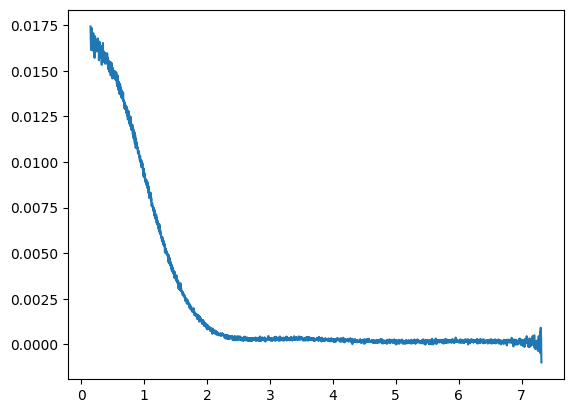

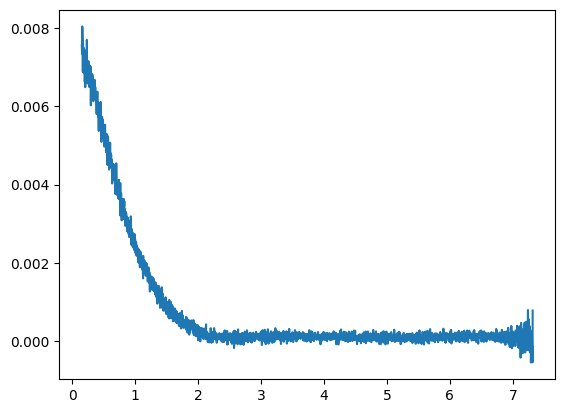

In [9]:
# построим графики для проверки. Похоже на спектр.
for i in ["1_1", "1_13", "2_19"]:
#     spectr_df[i]["intensity"].plot.bar(xticks=[])
    plt.plot(spectr_df[i]["scattering_angle"], spectr_df[i]["intensity"])
    plt.show()

In [10]:
intensity_lst = []
id_lst = []

for obj_idx in spectr_df.keys():
    spectr_df[obj_idx].drop("scattering_angle", axis=1, inplace=True) # удаляю угол
    intensity_lst.append(spectr_df[obj_idx].T) # запихиваю все интенсивности в один список
    id_lst.append(obj_idx)

In [11]:
# склеиваю все интенсивности для каждого объекта в одну таблицу. Индексом ставим id кристалла
intensity_df = pd.concat(intensity_lst)
intensity_df.index = id_lst
intensity_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576
1_10,0.015204,0.015595,0.014513,0.015322,0.015911,0.016054,0.016275,0.016414,0.016364,0.016525,...,0.000354,-0.000526,0.000580,0.000166,0.000465,-0.000197,0.001208,-0.000295,-0.001411,-0.000061
1_11,0.019323,0.019261,0.019730,0.019324,0.018704,0.019049,0.019382,0.019100,0.018756,0.018227,...,-0.000352,-0.000044,-0.000442,-0.000224,-0.000141,-0.000200,0.000938,0.000285,-0.000714,0.000793
1_13,0.017424,0.017039,0.016708,0.016138,0.016734,0.017310,0.016568,0.017152,0.017331,0.016165,...,0.000347,0.000196,0.000694,-0.000483,-0.000056,0.000911,0.000445,0.000475,-0.000155,-0.000995
1_14,0.012603,0.012585,0.012807,0.012688,0.012501,0.012358,0.012127,0.012399,0.012862,0.012107,...,-0.000454,0.000445,-0.000407,0.000350,-0.000147,-0.000461,-0.000753,0.000183,-0.000301,-0.000997
1_15,0.015187,0.015511,0.015361,0.015478,0.015671,0.015139,0.015380,0.015419,0.015293,0.015504,...,-0.000285,-0.000243,0.000146,0.000221,-0.000565,-0.000096,-0.000321,0.000688,0.000112,-0.000591


In [12]:
df = intensity_df.join(crys_df) # собрали датасет воедино

In [13]:
df.shape

(56, 2581)

In [14]:
df

,0,1,2,3,4,5,6,7,8,9,...,2571,2572,2573,2574,2575,2576,crystallization,R,dimer,octamer
1_10,0.015204,0.015595,0.014513,0.015322,0.015911,0.016054,0.016275,0.016414,0.016364,0.016525,...,0.000465,-0.000197,0.001208,-0.000295,-0.001411,-0.000061,нет,15.5,9.3,0.0
1_11,0.019323,0.019261,0.019730,0.019324,0.018704,0.019049,0.019382,0.019100,0.018756,0.018227,...,-0.000141,-0.000200,0.000938,0.000285,-0.000714,0.000793,нет,15.0,5.4,0.0
1_13,0.017424,0.017039,0.016708,0.016138,0.016734,0.017310,0.016568,0.017152,0.017331,0.016165,...,-0.000056,0.000911,0.000445,0.000475,-0.000155,-0.000995,нет,14.3,0.0,0.0
1_14,0.012603,0.012585,0.012807,0.012688,0.012501,0.012358,0.012127,0.012399,0.012862,0.012107,...,-0.000147,-0.000461,-0.000753,0.000183,-0.000301,-0.000997,нет,14.3,0.0,0.0
1_15,0.015187,0.015511,0.015361,0.015478,0.015671,0.015139,0.015380,0.015419,0.015293,0.015504,...,-0.000565,-0.000096,-0.000321,0.000688,0.000112,-0.000591,нет,14.3,0.0,0.0
1_16,0.016613,0.016342,0.016100,0.016849,0.016388,0.016375,0.015699,0.016309,0.016204,0.016243,...,0.000737,0.000035,0.000257,-0.000471,0.000616,0.001034,нет,14.5,1.7,0.0
1_17,0.014560,0.014204,0.013854,0.013830,0.014655,0.013905,0.014425,0.013696,0.013796,0.013681,...,-0.000961,-0.000372,0.000062,0.000867,-0.002361,-0.001055,нет,16.3,18.4,0.0
1_18,0.014603,0.015646,0.015562,0.014946,0.015192,0.015477,0.015546,0.015472,0.015267,0.015261,...,0.000133,0.000978,-0.000530,0.000663,0.000736,0.000674,нет,14.3,0.0,0.0
1_1,0.016250,0.015911,0.015469,0.016117,0.015550,0.014891,0.015256,0.015498,0.015291,0.015053,...,0.000858,-0.000237,0.000300,-0.000509,0.000669,0.000504,нет,14.3,0.0,0.0
1_20,0.019304,0.019266,0.018843,0.019077,0.019051,0.018925,0.019914,0.019187,0.019442,0.018299,...,-0.000344,0.000605,0.000429,0.000839,0.001052,-0.000523,нет,17.1,25.9,0.1


# Обучение (Классификация)

In [15]:
from sklearn.model_selection import LeaveOneOut

In [16]:
# кодируем отклик
le = LabelEncoder()
le.fit(df["crystallization"])
df["crystallization"] = le.transform(df["crystallization"])

In [17]:
# разделяем отклик и признаки
X = df.drop(["crystallization", "dimer", "octamer", "R"], axis=1)
y = df["crystallization"]

Модели которые нужно попробовать:
* ExtraTrees
* SVC
* Logistic
* MLP

In [18]:
# скалирование (чтобы всё было +- в одном диапазоне)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Метод снижения размерности
pca = PCA(n_components=50)
pca.fit(X_scaled)
pca.explained_variance_ratio_

array([7.70880544e-01, 1.83830413e-01, 1.03799226e-02, 9.33711004e-03,
       2.09390520e-03, 1.25567957e-03, 1.13137075e-03, 9.24118146e-04,
       8.61635995e-04, 8.39567527e-04, 7.96347594e-04, 7.69295040e-04,
       7.09892779e-04, 6.80615121e-04, 6.67870556e-04, 6.22933501e-04,
       6.13012734e-04, 5.81938756e-04, 5.62624286e-04, 5.52819439e-04,
       5.16048751e-04, 4.99438190e-04, 4.89498248e-04, 4.81529911e-04,
       4.74785459e-04, 4.54998591e-04, 4.42134513e-04, 4.31952680e-04,
       4.17316657e-04, 4.04107318e-04, 3.98003412e-04, 3.85930772e-04,
       3.75216946e-04, 3.52903869e-04, 3.42641983e-04, 3.42219898e-04,
       3.29647137e-04, 3.20641754e-04, 3.15997882e-04, 3.05273391e-04,
       2.99691014e-04, 2.94051537e-04, 2.87633988e-04, 2.78656403e-04,
       2.70643831e-04, 2.65819984e-04, 2.60895834e-04, 2.54683354e-04,
       2.44632725e-04, 2.43462150e-04])

In [20]:
# Применение PCA
pca = PCA(n_components=3, random_state=123)
X_pca = pca.fit_transform(X_scaled)

## Первая модель

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

In [22]:
clf = ExtraTreesClassifier(random_state=123)
cvs = cross_val_score(clf, X_pca, y, cv=5, scoring="accuracy")
print("accuracy:", cvs.mean())

accuracy: 0.6242424242424243


## Вторая модель

In [23]:
clf = svm.SVC(C=1, kernel="rbf")
cvs = cross_val_score(clf, X, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

accuracy: 0.6607142857142857


## Третья модель

In [24]:
clf = LogisticRegression(C=3, multi_class="ovr")
cvs = cross_val_score(clf, X_pca, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

accuracy: 0.7678571428571429


C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

## дополнительные действия

In [25]:
# посмотрим корреляции признаков с откликом
corrs = []
for col in X.columns:
    corrs.append((abs(np.corrcoef(X[col], y)[1][0]), col))

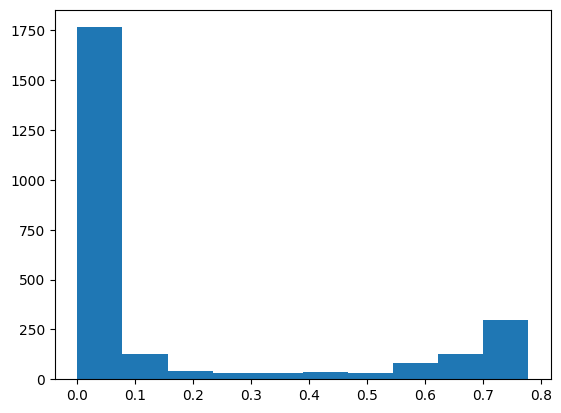

In [26]:
plt.hist(np.array(corrs)[:, 0])
plt.show()

In [27]:
# Берем только фичи, коррелирующие с откликом с корреляцией > 0.2
good_features = []
for corr, col in corrs:
    if corr > 0.2:
        good_features.append(col)

In [28]:
X_correlate = X[good_features] # можно брать фичи из X_scaled уже

## Четвертая модель

In [29]:
# Первый вариант

# Кросс-валидация на нейросети с коррелирующими данными
clf = MLPClassifier((100, 10), max_iter=2000, random_state=123)
cvs = cross_val_score(clf, X_correlate, y, cv=5, scoring="accuracy")
print("accuracy:", cvs.mean())

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy: 0.7303030303030303


C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [31]:
# Второй вариант

# без использования коррелирующих данных
clf = MLPClassifier((100, 10), max_iter=1000, random_state=123)
cvs = cross_val_score(clf, X_pca, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

accuracy: 0.5892857142857143


C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### обучила дополнительно

In [60]:
# другие модели
clf = KNeighborsClassifier()
cvs = cross_val_score(clf, X_pca, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

ValueError: 
All the 56 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
56 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py", line 238, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py", line 499, in _fit
    check_classification_targets(y)
  File "C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\multiclass.py", line 219, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


**Комментарий:**  
  
Задание 1:  
Визуализировать предсказание лучшей модели с помощью confusion matrix (есть в sklearn)  
  
Задание 2:  
2.1 Отобрать (любым подходящим методом) два лучших признака  
2.2 Обучить на них одну линейную и одну нелинейную модели  
2.3 Постороить тепловые карты предсказания, используя обученные модели (код есть в одном из ноутбуков). Нанести на нее точки исходной выборки, истинный класс каждой точки обозначить цветом.  

**Задание 1**

In [32]:
best_model = LogisticRegressionCV()

In [33]:
#v_predict = cross_val_predict(best_model, X, y, cv=LeaveOneOut())

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [34]:
accuracy_score(y, v_predict)

0.6607142857142857

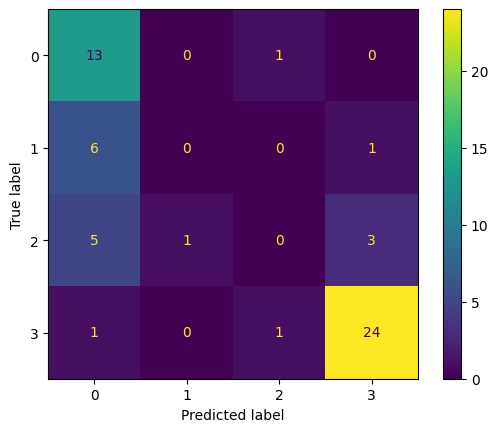

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_true = y # тут вектор разметки
y_pred = v_predict # тут вектор предсказания
cm = confusion_matrix(y_true, y_pred,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**Задание 2**

In [36]:
#2.1
corrs = np.array(corrs)[:, 0].flatten()
corrs

array([0.33717644, 0.35419061, 0.38258137, ..., 0.20996933, 0.15595824,
       0.06947108])

In [37]:
X_best = X.to_numpy()[:, np.argsort(corrs)[::-1]][:, :2]
X_best

array([[0.00800405, 0.00964756],
       [0.00951901, 0.01174262],
       [0.00957151, 0.01148893],
       [0.00835174, 0.01001597],
       [0.00855062, 0.01051958],
       [0.00836833, 0.01037862],
       [0.00619917, 0.00796006],
       [0.00820873, 0.00963601],
       [0.0090274 , 0.0109313 ],
       [0.00792857, 0.0097716 ],
       [0.00861699, 0.01089699],
       [0.00625318, 0.00678155],
       [0.00943268, 0.01149584],
       [0.00982784, 0.01256317],
       [0.00878969, 0.0106201 ],
       [0.00527551, 0.00682135],
       [0.00769236, 0.00983651],
       [0.00437109, 0.00561295],
       [0.00898626, 0.0107634 ],
       [0.00410689, 0.00528186],
       [0.00437164, 0.00569017],
       [0.00474139, 0.00591064],
       [0.00477325, 0.00570704],
       [0.00322896, 0.00462172],
       [0.00822168, 0.01023608],
       [0.00535856, 0.00673578],
       [0.00681008, 0.00885685],
       [0.00812179, 0.00976086],
       [0.00564168, 0.00740387],
       [0.00485741, 0.00661326],
       [0.

In [38]:
#2.2.1 (ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
clf = LogisticRegression(C=3, multi_class="ovr")
cvs = cross_val_score(clf, X_best, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

accuracy: 0.4642857142857143


C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [39]:
#2.2.2 (ОБУЧЕНИЕ НЕЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
clf = MLPClassifier((100, 10), max_iter=2000, random_state=123)
cvs = cross_val_score(clf, X_best, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

accuracy: 0.4642857142857143


(0.002521895, 0.01256317)

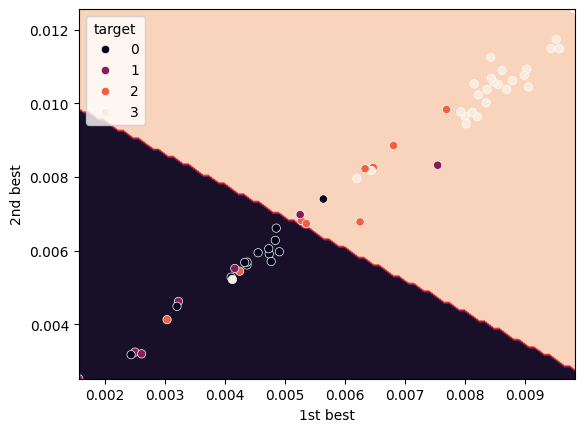

In [40]:
#2.3

fig, ax = plt.subplots()
best_model.fit(X_best, y)

xlim = (X_best[:, 0].min(), X_best[:, 0].max())
ylim = (X_best[:, 1].min(), X_best[:, 1].max())
grid_x = np.linspace(*xlim, 100)
grid_y = np.linspace(*ylim, 100)
xx, yy = np.meshgrid(grid_x, grid_y)
grid = np.c_[xx.ravel(), yy.ravel()]
prediction = best_model.predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, prediction, cmap=sns.color_palette("rocket", as_cmap=True))

ax = sns.scatterplot(data=pd.DataFrame(data={'1st best': X_best[:, 0], '2nd best': X_best[:, 1], 'target': y}),
                     x='1st best', y='2nd best', hue='target', palette="rocket", ax=ax)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

# Обучение (Регрессия)

In [41]:
# предсказываю R
y = df["R"]

**Комментарий:**

Модели которые нужно попробовать:
* ExtraTrees
* SVR
* Ridge
* MLP

Для оценки качества также использовать R<sup>2</sup>-score

### Первая модель

In [50]:
clf = ExtraTreesRegressor()
ypred = cross_val_predict(clf, X_pca, y, cv=LeaveOneOut())
r2_score(df["R"], ypred)

0.7639912373921177

### Вторая модель

In [51]:
from sklearn.svm import SVR

In [52]:
clf = SVR()
ypred = cross_val_predict(clf, X_pca, y, cv=LeaveOneOut())
r2_score(df["R"], ypred)

0.6467189214796751

### Третья модель

In [55]:
clf = RidgeCV()
ypred = cross_val_predict(clf, X, y, cv=LeaveOneOut())
r2_score(df["R"], ypred)

0.4669595693893115

### Четвертая модель

In [54]:
clf = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)
ypred1 = cross_val_predict(clf, X, y, cv=LeaveOneOut())
r2_score(df["R"], ypred1)

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

0.8688579782982631

**Комментарий:**  
  
Задание 1:  
Визуализировать предсказание лучшей модели с помощью true-preddicted scatterplot (используя, например, библиотеку seaborn)  
  
Задание 2:  
2.1 Отобрать (любым подходящим методом) два лучших признака  
2.2 Обучить на них одну линейную и одну нелинейную модели  
2.3 Постороить тепловые карты предсказания, используя обученные модели (код есть в одном из ноутбуков). Нанести на нее точки исходной выборки, истинное значение таргета в каждой точке обозначить цветом.  

### Задание 1

In [42]:
 #pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
best_model1 = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)

In [57]:
clf = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)
ypred1 = cross_val_predict(clf, X, y, cv=LeaveOneOut())

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='R'>

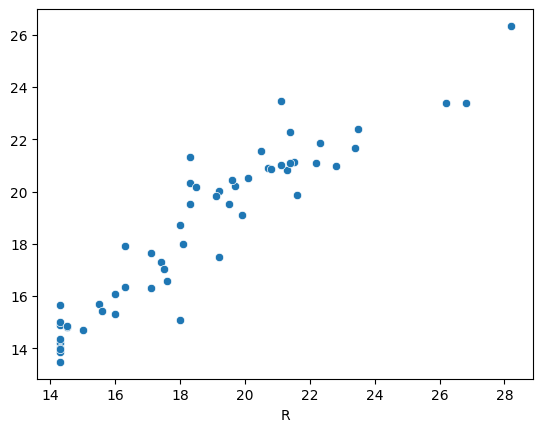

In [58]:
sns.scatterplot(x=y, y=ypred1)
#y_true - реальные метки
#y_pred - предсказания

### Задание 2

In [43]:
#2.1
clf = ExtraTreesRegressor()
clf.fit(X, y)
a = clf.feature_importances_
X_best1 = X.to_numpy()[:, np.argsort(a)[::-1]][:, :2]
X_best1

array([[0.00384399, 0.00780416],
       [0.00479107, 0.0090185 ],
       [0.00483857, 0.00914937],
       [0.00422284, 0.00797931],
       [0.00430356, 0.00862542],
       [0.00430484, 0.00836203],
       [0.00324557, 0.00646456],
       [0.00396477, 0.00763666],
       [0.00456153, 0.00875942],
       [0.00381881, 0.00766595],
       [0.00419736, 0.00816142],
       [0.00223928, 0.00512917],
       [0.00471233, 0.0090438 ],
       [0.00452098, 0.00965586],
       [0.0040893 , 0.00823509],
       [0.00237083, 0.00508954],
       [0.00369183, 0.00781791],
       [0.00208953, 0.00420634],
       [0.0040045 , 0.00829674],
       [0.00199485, 0.00410745],
       [0.00214334, 0.00439276],
       [0.00254195, 0.0046672 ],
       [0.00209077, 0.00438196],
       [0.00162757, 0.00311143],
       [0.00402311, 0.00805548],
       [0.00247233, 0.0049468 ],
       [0.0033577 , 0.00669211],
       [0.00410233, 0.00785067],
       [0.00266393, 0.00539388],
       [0.00228956, 0.00492481],
       [0.

In [44]:
#2.2.1 (ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
clf = RidgeCV()
ypred = cross_val_predict(clf, X_best1, y, cv=LeaveOneOut())
r2_score(df["R"], ypred)

-0.03193895045548745

In [45]:
#2.2.2 (ОБУЧЕНИЕ НЕЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
clf = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)
ypred = cross_val_predict(clf, X_best1, y, cv=LeaveOneOut())
r2_score(df["R"], ypred)

-0.05213279910784241

(0.001641415, 0.009655865)

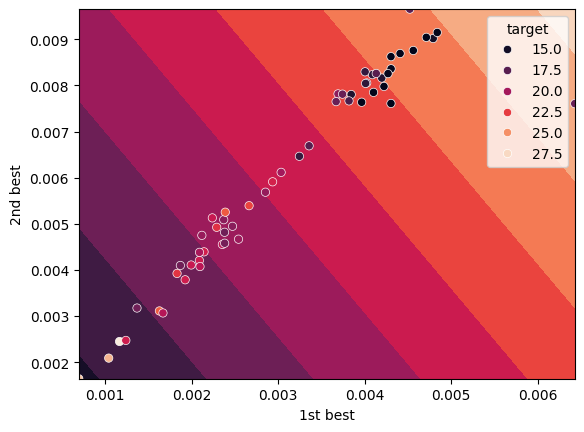

In [47]:
# 2.3

fig, ax = plt.subplots()
clf.fit(X_best1, y)

xlim = (X_best1[:, 0].min(), X_best1[:, 0].max())
ylim = (X_best1[:, 1].min(), X_best1[:, 1].max())
grid_x = np.linspace(*xlim, 100)
grid_y = np.linspace(*ylim, 100)
xx, yy = np.meshgrid(grid_x, grid_y)
grid = np.c_[xx.ravel(), yy.ravel()]
prediction = clf.predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, prediction, cmap=sns.color_palette("rocket", as_cmap=True))

ax = sns.scatterplot(data=pd.DataFrame(data={'1st best': X_best1[:, 0], '2nd best': X_best1[:, 1], 'target': y}),
                     x='1st best', y='2nd best', hue='target', palette="rocket", ax=ax)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)


In [ ]:
#просто пустая строка

In [ ]:
#просто пустая строка

In [ ]:
#просто пустая строка

### Идеи и предложения

Новые признаки, которые стоит попробовать:

Максимальное/минимальное/среднее/дисперсия/различные квантили значение интенсивности; \
Угол рассеивания с максимальной/минимальной интенсивностью; \
и т. д.